### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Autoencoder import Autoencoder
from GMM import GMM
from PCA import PCA
from KMeans import KMeans
from sklearn.metrics import silhouette_score

### Data Loading and Preprocessing

In [3]:
df = pd.read_csv('data.csv').drop(columns=['id', 'Unnamed: 32'], errors='ignore')
X_raw = df.drop(columns=['diagnosis']).values

X = (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)
input_dim = X.shape[1]
print(input_dim)

30


### Autoencoder Training

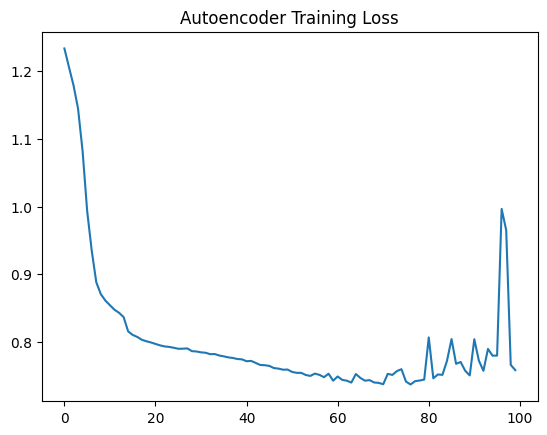

In [4]:
np.random.seed(42)
# Architecture: Input(30) -> 20 -> 15 -> 10 -> Bottleneck(2) -> 10 -> 15 -> 20 -> Input(30)
layers = [input_dim, 20, 15, 10, 2, 10, 15, 20, input_dim]
activations = ['relu', 'relu', 'relu', 'tanh', 'relu', 'relu', 'relu', 'sigmoid']

ae_model = Autoencoder(layers, activations, lr=0.01, l2_reg=0.001)
history = ae_model.train(X, epochs=100)

X_reduced = ae_model.get_bottleneck(X)

plt.plot(history)
plt.title("Autoencoder Training Loss")
plt.show()

### PCA

Shape after PCA: (569, 10)
Explained variance ratio: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978]
Cumulative variance: 0.9515688143366668
Reconstruction error: 0.04843118566333323


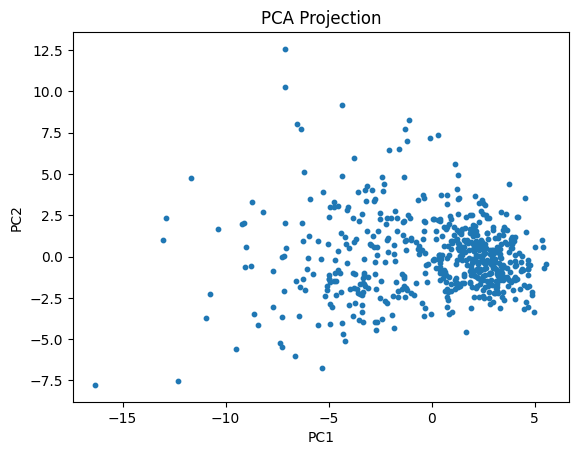

In [5]:
pca = PCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)
print("Shape after PCA:",X_pca.shape)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", np.sum(pca.explained_variance_ratio_))
print("Reconstruction error:", pca.reconstruction_error(X, X_pca))

#valid when choosing n_components = 2, else it doesnt show the full variance
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")
plt.show()

### Experiment 1 (K-Means on original data)

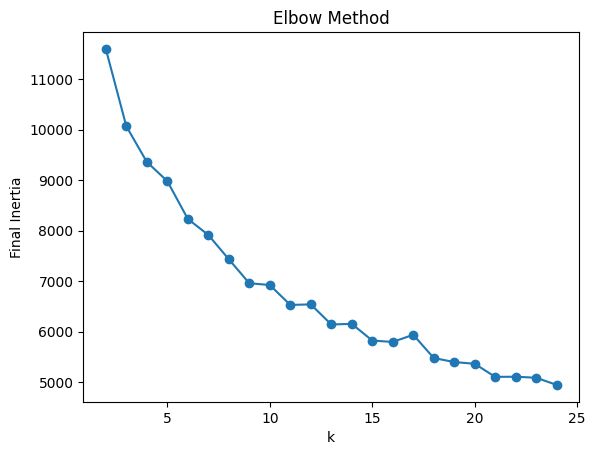

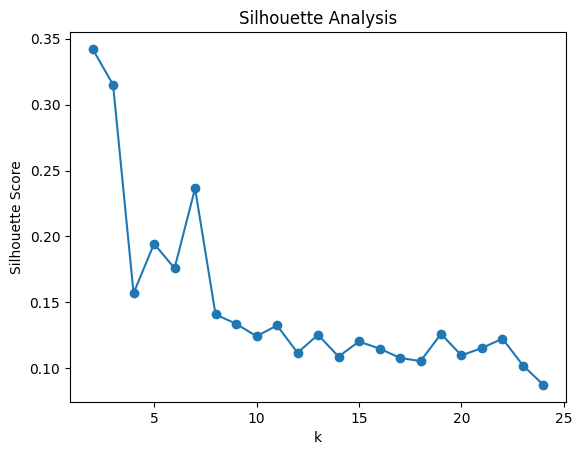

In [6]:
k_values = range(2, 25)  # silhouette undefined for k=1
inertia_list = []
sil_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init="kmeans++")
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_history_[-1])
    score = silhouette_score(X, kmeans.labels_)
    sil_scores.append(score)

plt.plot(k_values, inertia_list, marker='o')
plt.xlabel("k")
plt.ylabel("Final Inertia")
plt.title("Elbow Method")
plt.show()
"""
Silhouette score = “On average, are the points closer to their own cluster mates than to points in other clusters?”
it takes the average distance of each point with other points in its cluster and the same for the points of the nearest cluster
1 = very good clusters
0 = borderline
Negative → points probably assigned incorrectly
"""
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

k=1, Gap=1.6408
k=2, Gap=1.9572
k=3, Gap=2.0550
k=4, Gap=2.0814
k=5, Gap=2.1566
k=6, Gap=2.2198
k=7, Gap=2.2525
k=8, Gap=2.2119
k=9, Gap=2.3056
k=10, Gap=2.2989
k=11, Gap=2.3216
k=12, Gap=2.3793
k=13, Gap=2.3664
k=14, Gap=2.3908
k=15, Gap=2.4411
k=16, Gap=2.4104
k=17, Gap=2.4196
k=18, Gap=2.4725
k=19, Gap=2.4573
k=20, Gap=2.4839
k=21, Gap=2.5066
k=22, Gap=2.5158
k=23, Gap=2.4954
k=24, Gap=2.5177


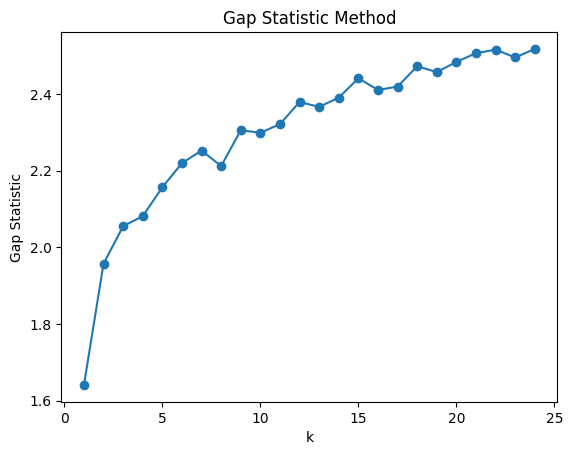

In [7]:
def compute_gap_statistic(X, k, B=10):
    """
    X: (n_samples, n_features) original data
    k: number of clusters
    B: number of reference datasets
    """
    # Fit K-Means on real data
    kmeans = KMeans(n_clusters=k, init="kmeans++")
    kmeans.fit(X)
    Wk = kmeans.inertia_history_[-1]  # final inertia

    # Fit K-Means on B reference datasets
    Wk_refs = []
    n_samples, n_features = X.shape
    X_min, X_max = X.min(axis=0), X.max(axis=0)

    for b in range(B):
        # Uniform reference data in same bounds
        X_ref = np.random.uniform(low=X_min, high=X_max, size=(n_samples, n_features))
        kmeans_ref = KMeans(n_clusters=k, init="kmeans++", max_iter=100, tol=1e-4)
        kmeans_ref.fit(X_ref)
        Wk_refs.append(kmeans_ref.inertia_history_[-1])

    Wk_ref_log_mean = np.log(np.mean(Wk_refs))
    gap = Wk_ref_log_mean - np.log(Wk)
    return gap
"""
A bigger gap means:
The real data’s clusters are much tighter than random uniform clusters
The clustering is meaningful
"""
k_values = range(1, 25)
gaps = []

for k in k_values:
    gap = compute_gap_statistic(X, k, B=10)
    gaps.append(gap)
    print(f"k={k}, Gap={gap:.4f}")

# Plot Gap Statistic
plt.plot(k_values, gaps, marker='o')
plt.xlabel("k")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic Method")
plt.show()

random initialization:
  Iterations to converge: 28
  Final inertia: 8651.8892

kmeans++ initialization:
  Iterations to converge: 16
  Final inertia: 8993.8444



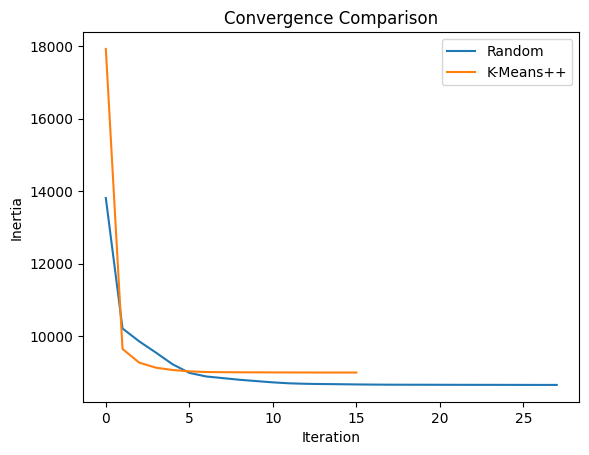

In [8]:
def compare_initializations(X, n_clusters=2, max_iter=100, tol=1e-4):
    results = {}

    for init_method in ["random", "kmeans++"]:
        kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=max_iter, tol=tol)
        kmeans.fit(X)
        
        # Number of iterations until convergence
        n_iterations = len(kmeans.inertia_history_)
        final_inertia = kmeans.inertia_history_[-1]
        
        results[init_method] = {
            "iterations": n_iterations,
            "final_inertia": final_inertia,
            "inertia_history": kmeans.inertia_history_,  # <-- add this
            "centroids": kmeans.centroids_,
            "labels": kmeans.labels_
        }
        print(f"{init_method} initialization:")
        print(f"  Iterations to converge: {n_iterations}")
        print(f"  Final inertia: {final_inertia:.4f}\n")

    plt.plot(results["random"]["inertia_history"], label="Random")
    plt.plot(results["kmeans++"]["inertia_history"], label="K-Means++")
    plt.xlabel("Iteration")
    plt.ylabel("Inertia")
    plt.title("Convergence Comparison")
    plt.legend()
    plt.show()


    return results
results = compare_initializations(X, n_clusters=5)

### Experiment 2 (GMM on Original Data)

Experiment 2: GMM on Original Data


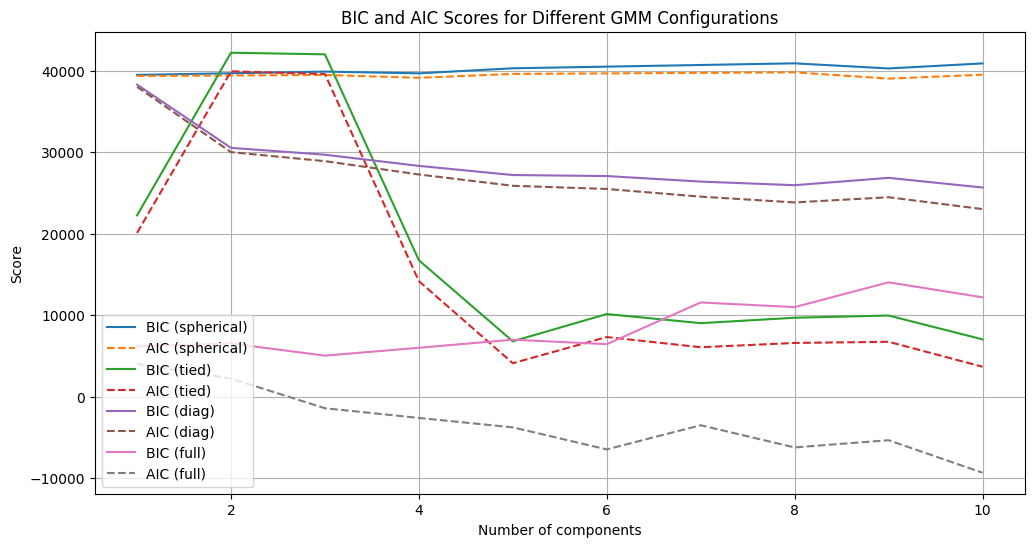

Best model found: 3 components with 'full' covariance.
Lowest BIC: 5026.18

Analyzing log-likelihood convergence for the best model...


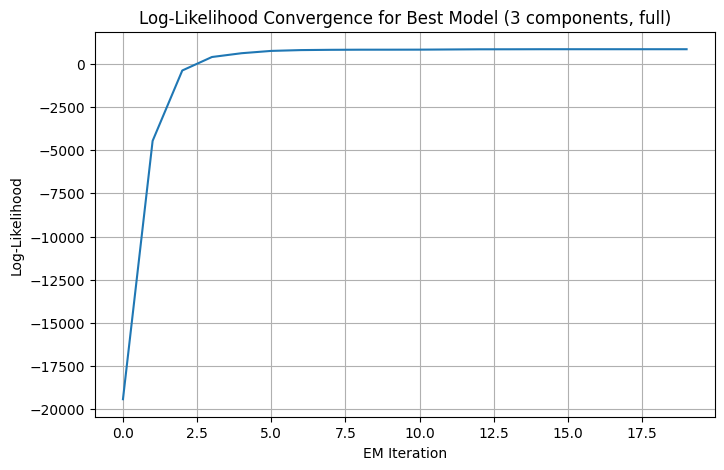

In [9]:
np.random.seed(42)
print("Experiment 2: GMM on Original Data")

# Define the range of components and covariance types to test
n_components_range = range(1, 11)
cov_types = ['spherical', 'tied', 'diag', 'full']
results = []
lowest_bic = np.inf
best_gmm = None

# Iterate over covariance types and number of components
for cov_type in cov_types:
    bics = []
    aics = []
    for n_components in n_components_range:
        gmm = GMM(n_components=n_components, cov_type=cov_type)
        gmm.fit(X)
        bics.append(gmm.bic)
        aics.append(gmm.aic)
        
        # Keep track of the best model based on BIC
        if gmm.bic < lowest_bic:
            lowest_bic = gmm.bic
            best_gmm = gmm
            
    results.append({'type': cov_type, 'bics': bics, 'aics': aics})

# Plot BIC and AIC scores
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(n_components_range, res['bics'], label=f"BIC ({res['type']})")
    plt.plot(n_components_range, res['aics'], linestyle='--', label=f"AIC ({res['type']})")

plt.title('BIC and AIC Scores for Different GMM Configurations')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best model found: {best_gmm.k} components with '{best_gmm.cov_type}' covariance.")
print(f"Lowest BIC: {lowest_bic:.2f}")

# Analyze log-likelihood convergence for the best model
print("\nAnalyzing log-likelihood convergence for the best model...")
# We need to re-fit the best model to get its log-likelihood history
best_gmm_final = GMM(n_components=best_gmm.k, cov_type=best_gmm.cov_type)
log_likelihood_history = best_gmm_final.fit(X)

plt.figure(figsize=(8, 5))
plt.plot(log_likelihood_history)
plt.title(f'Log-Likelihood Convergence for Best Model ({best_gmm.k} components, {best_gmm.cov_type})')
plt.xlabel('EM Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

### Experiment 3 (K-Means after PCA)

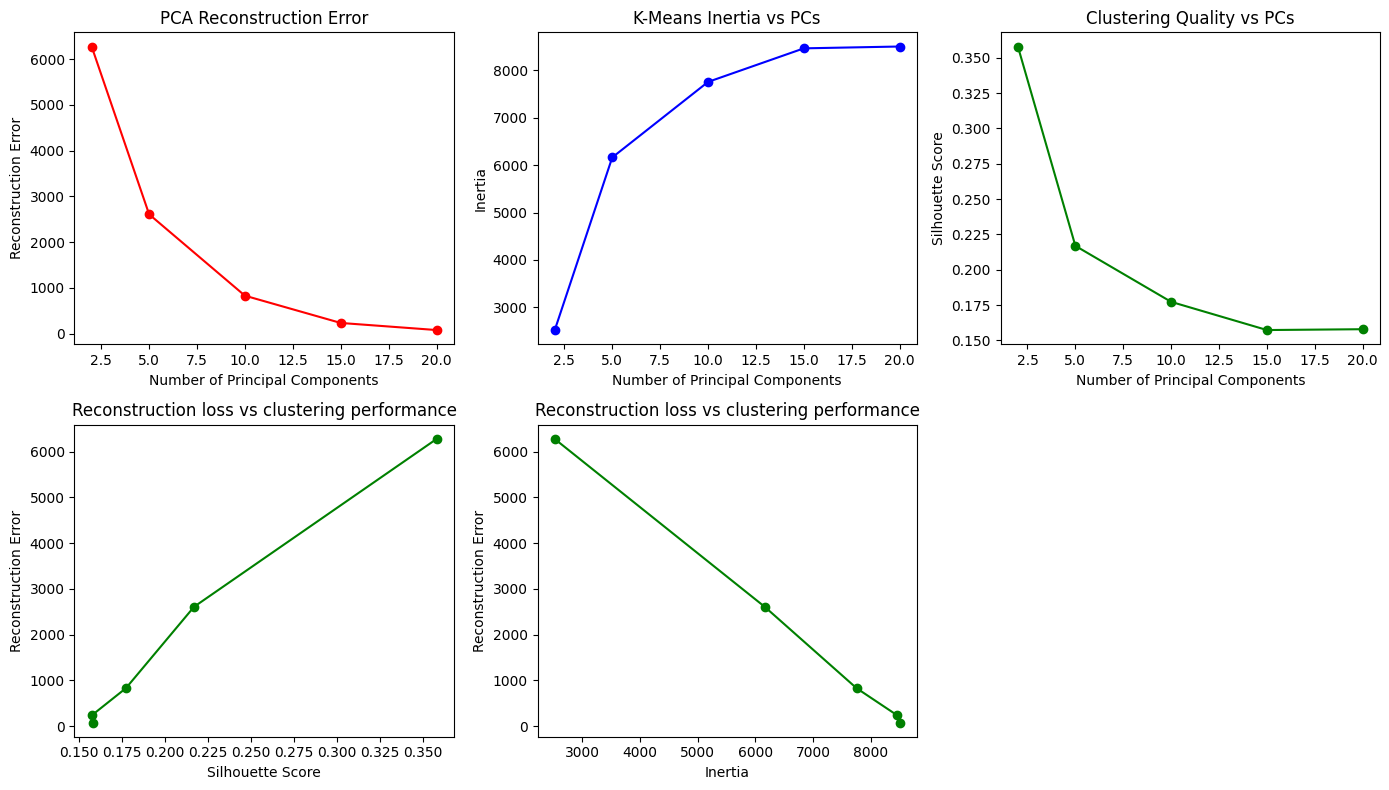

In [10]:
test_sizes = [2, 5, 10, 15, 20]
results = []

for n_pc in test_sizes:
    # PCA reduction
    pca = PCA(n_components=n_pc)
    pca.fit(X)
    X_reduced = pca.transform(X)
    # Reconstruction
    X_reconstructed = pca.inverse_transform(X_reduced)
    recon_error = np.sum((X - X_reconstructed)**2)

    # K-Means clustering
    kmeans = KMeans(n_clusters=5, init="kmeans++", max_iter=100, tol=1e-4)
    kmeans.fit(X_reduced)

    # Clustering quality
    inertia = kmeans.inertia_history_[-1]
    from sklearn.metrics import silhouette_score
    silhouette = silhouette_score(X_reduced, kmeans.labels_)
    
    results.append({
        "reconstruction_error": recon_error,
        "inertia": inertia,
        "silhouette": silhouette
    })

# Plot results
recon = [r["reconstruction_error"] for r in results]
silh = [r["silhouette"] for r in results]
inertias = [r["inertia"] for r in results]
# Plot reconstruction error vs number of PCs
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.plot(test_sizes, recon, marker='o', color='red')
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction Error")

# Plot inertia vs number of PCs
plt.subplot(2,3,2)
plt.plot(test_sizes, inertias, marker='o', color='blue')
plt.xlabel("Number of Principal Components")
plt.ylabel("Inertia")
plt.title("K-Means Inertia vs PCs")

# Plot silhouette vs number of PCs
plt.subplot(2,3,3)
plt.plot(test_sizes, silh, marker='o', color='green')
plt.xlabel("Number of Principal Components")
plt.ylabel("Silhouette Score")
plt.title("Clustering Quality vs PCs")

plt.subplot(2,3,4)
plt.plot(silh, recon, marker='o', color='green')
plt.xlabel("Silhouette Score")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.subplot(2,3,5)
plt.plot(inertias,recon, marker='o', color='green')
plt.xlabel("Inertia")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.tight_layout()
plt.show()

### Experiment 4 (GMM after PCA)

In [11]:
np.random.seed(42)
print("Experiment 4: GMM after PCA")

# Define parameter ranges
pca_dims = [2, 5, 10, 15, 20]
cov_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 11)

# Store results
results_pca_gmm = []

# Iterate over PCA dimensions
for dim in pca_dims:
    print(f"\n--- Testing PCA with {dim} dimensions ---")
    
    # Apply PCA
    pca = PCA(n_components=dim)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    best_bic_for_dim = np.inf
    best_config_for_dim = {}

    # Iterate over covariance types
    for cov_type in cov_types:
        lowest_bic = np.inf
        best_gmm_for_cov = None
        
        # Find the best number of components for the current cov_type
        for n_components in n_components_range:
            gmm = GMM(n_components=n_components, cov_type=cov_type)
            gmm.fit(X_pca)
            
            if gmm.bic < lowest_bic:
                lowest_bic = gmm.bic
                best_gmm_for_cov = gmm
        
        print(f"  Best for '{cov_type}': {best_gmm_for_cov.k} components, BIC: {lowest_bic:.2f}")
        
        results_pca_gmm.append({
            'pca_dim': dim,
            'cov_type': cov_type,
            'best_k': best_gmm_for_cov.k,
            'bic': lowest_bic
        })

# Display results in a DataFrame for easy comparison
results_df = pd.DataFrame(results_pca_gmm)
pivot_df = results_df.pivot(index='pca_dim', columns='cov_type', values='bic')

print("\n\n--- BIC Scores for GMM on PCA-reduced Data ---")
print(pivot_df)

print("\n--- Optimal Covariance Type per Dimension ---")
print(pivot_df.idxmin(axis=1))

Experiment 4: GMM after PCA

--- Testing PCA with 2 dimensions ---
  Best for 'spherical': 2 components, BIC: 6023.57
  Best for 'tied': 8 components, BIC: 5492.73
  Best for 'diag': 2 components, BIC: 5417.28
  Best for 'full': 2 components, BIC: 5414.72

--- Testing PCA with 5 dimensions ---
  Best for 'spherical': 2 components, BIC: 14974.21
  Best for 'tied': 8 components, BIC: 11403.50
  Best for 'diag': 4 components, BIC: 11267.27
  Best for 'full': 4 components, BIC: 11142.09

--- Testing PCA with 10 dimensions ---
  Best for 'spherical': 1 components, BIC: 30112.55
  Best for 'tied': 7 components, BIC: 17426.34
  Best for 'diag': 4 components, BIC: 17060.98
  Best for 'full': 3 components, BIC: 17213.58

--- Testing PCA with 15 dimensions ---
  Best for 'spherical': 1 components, BIC: 39332.64
  Best for 'tied': 6 components, BIC: 20136.87
  Best for 'diag': 3 components, BIC: 19742.85
  Best for 'full': 2 components, BIC: 19988.14

--- Testing PCA with 20 dimensions ---
  Best

### Experiment 5 (K-Means after Autoencoder)

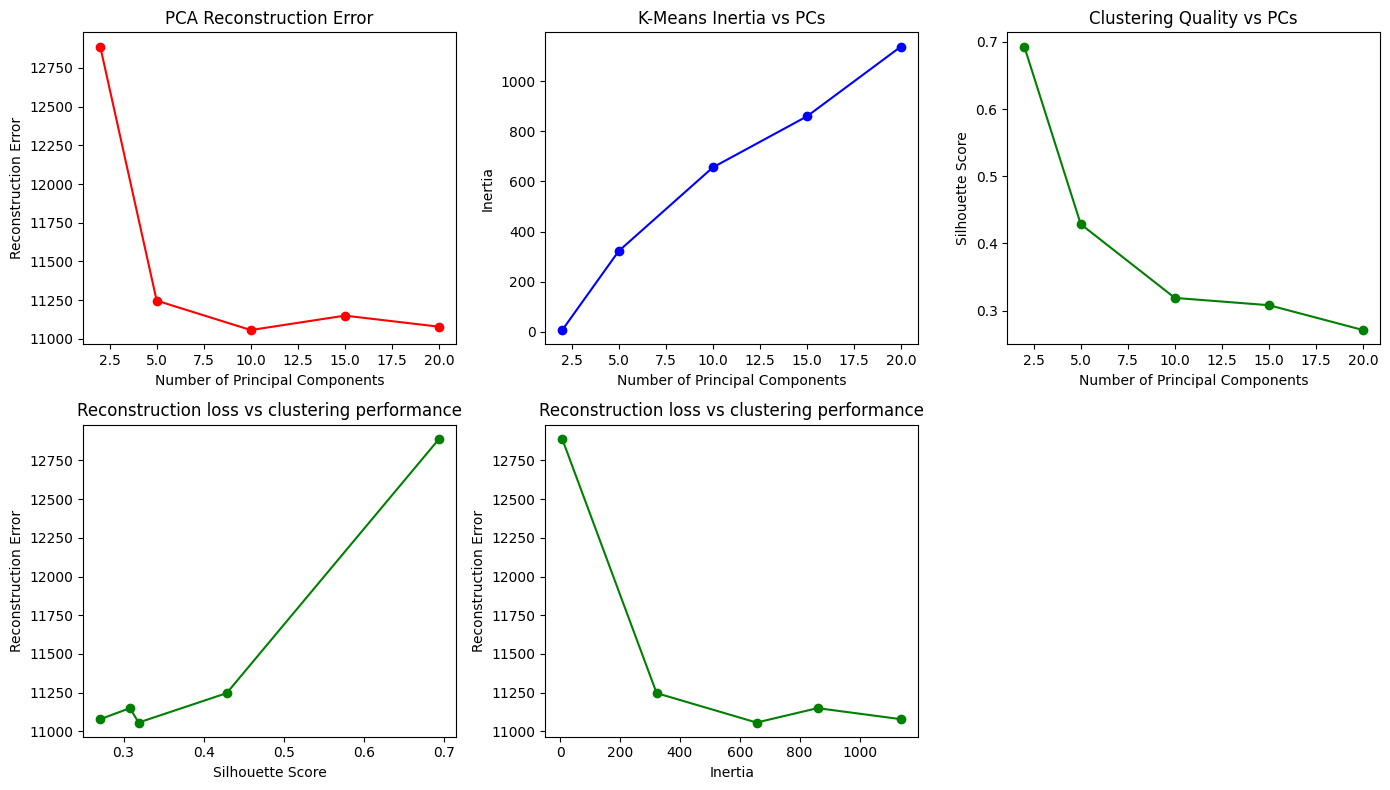

In [12]:
test_sizes = [2, 5, 10, 15, 20]
results = []

def build_layers(bottleneck):
    return np.round(np.concatenate([np.linspace(input_dim, bottleneck, 5), np.linspace(bottleneck, input_dim, 5)[1:]  ])).astype(int)
# Architecture: Input(30) -> 20 -> 15 -> 10 -> Bottleneck(2) -> 10 -> 15 -> 20 -> Input(30)

all_layers =[ build_layers(bottleneck) for bottleneck in test_sizes]
activations = ['relu', 'relu', 'relu', 'tanh', 'relu', 'relu', 'relu', 'sigmoid']
for layers_ in all_layers:
    ae_model = Autoencoder(layers_, activations, lr=0.01, l2_reg=0.001)
    ae_model.train(X, epochs=100)
    # Pre-calculate the reduced data for Experiment 6
    X_reduced = ae_model.get_bottleneck(X)
    # Reconstruction NOT IMPLEMENTED
    X_reconstructed = ae_model.decode(X_reduced)
    recon_error = np.sum((X - X_reconstructed)**2)
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=5, init="kmeans++", max_iter=100, tol=1e-4)
    kmeans.fit(X_reduced)

    # Clustering quality
    inertia = kmeans.inertia_history_[-1]
    from sklearn.metrics import silhouette_score
    silhouette = silhouette_score(X_reduced, kmeans.labels_)
    
    results.append({
        "reconstruction_error": recon_error,
        "inertia": inertia,
        "silhouette": silhouette
    })

# Plot results
recon = [r["reconstruction_error"] for r in results]
silh = [r["silhouette"] for r in results]
inertias = [r["inertia"] for r in results]
# Plot reconstruction error vs number of PCs
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.plot(test_sizes, recon, marker='o', color='red')
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction Error")

# Plot inertia vs number of PCs
plt.subplot(2,3,2)
plt.plot(test_sizes, inertias, marker='o', color='blue')
plt.xlabel("Number of Principal Components")
plt.ylabel("Inertia")
plt.title("K-Means Inertia vs PCs")

# Plot silhouette vs number of PCs
plt.subplot(2,3,3)
plt.plot(test_sizes, silh, marker='o', color='green')
plt.xlabel("Number of Principal Components")
plt.ylabel("Silhouette Score")
plt.title("Clustering Quality vs PCs")

plt.subplot(2,3,4)
plt.plot(silh, recon, marker='o', color='green')
plt.xlabel("Silhouette Score")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.subplot(2,3,5)
plt.plot(inertias,recon, marker='o', color='green')
plt.xlabel("Inertia")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.tight_layout()
plt.show()

### Experiment 6 (GMM after Autoencoder)

--- Experiment 6: GMM after Autoencoder ---

--- Testing Autoencoder with 2 dimensions ---
  Best BIC for AE-reduced data (dim=2): -3274.87

--- Testing Autoencoder with 5 dimensions ---
  Best BIC for AE-reduced data (dim=5): -4039.76

--- Testing Autoencoder with 10 dimensions ---
  Best BIC for AE-reduced data (dim=10): -10705.15

--- Testing Autoencoder with 15 dimensions ---
  Best BIC for AE-reduced data (dim=15): -8661.15

--- Testing Autoencoder with 20 dimensions ---
  Best BIC for AE-reduced data (dim=20): -9668.14


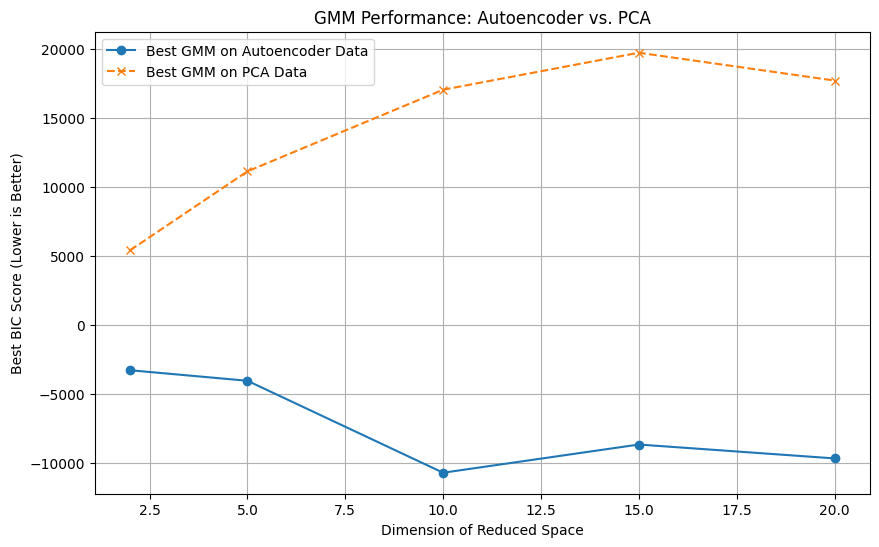


--- Final Comparison: Best BIC Scores ---
   dim        bic_AE       bic_PCA       winner
0    2  -3274.870911   5414.721037  Autoencoder
1    5  -4039.756774  11142.089535  Autoencoder
2   10 -10705.150164  17060.978147  Autoencoder
3   15  -8661.151687  19742.853251  Autoencoder
4   20  -9668.141576  17725.338903  Autoencoder


In [14]:
np.random.seed(42)
print("--- Experiment 6: GMM after Autoencoder ---")

# Define parameter ranges from previous experiments
dims = [2, 5, 10, 15, 20]
cov_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 11)

# Store results
results_ae_gmm = []

# Helper function to build AE architecture
def build_layers(bottleneck):
    encoder_layers = np.linspace(input_dim, bottleneck, 4, dtype=int)
    decoder_layers = np.linspace(bottleneck, input_dim, 4, dtype=int)[1:]
    return np.concatenate([encoder_layers, decoder_layers])

activations = ['relu', 'relu', 'tanh', 'relu', 'relu', 'sigmoid']

# Iterate over bottleneck dimensions
for dim in dims:
    print(f"\n--- Testing Autoencoder with {dim} dimensions ---")
    
    # 1. Build and train the Autoencoder
    layers = build_layers(dim)
    ae_model = Autoencoder(layers, activations, lr=0.01, l2_reg=0.001)
    ae_model.train(X, epochs=100)
    X_reduced_ae = ae_model.get_bottleneck(X)
    
    # 2. Find the best GMM for the AE-reduced data
    best_bic_for_dim = np.inf
    
    for cov_type in cov_types:
        for n_components in n_components_range:
            gmm = GMM(n_components=n_components, cov_type=cov_type)
            gmm.fit(X_reduced_ae)
            if gmm.bic < best_bic_for_dim:
                best_bic_for_dim = gmm.bic
    
    print(f"  Best BIC for AE-reduced data (dim={dim}): {best_bic_for_dim:.2f}")
    results_ae_gmm.append({'dim': dim, 'bic': best_bic_for_dim})

# --- Comparison with PCA-GMM results ---

# Create DataFrames from results
ae_gmm_df = pd.DataFrame(results_ae_gmm)

# Get the best BIC score for each dimension from the PCA-GMM experiment (Experiment 4)
# The pivot_df from Exp 4 has dims as index and cov_types as columns. We want the minimum BIC in each row.
best_pca_gmm_bic = pivot_df.min(axis=1).reset_index(name='bic')
best_pca_gmm_bic = best_pca_gmm_bic.rename(columns={'pca_dim': 'dim'})


# --- Plotting and Final Determination ---
plt.figure(figsize=(10, 6))
plt.plot(ae_gmm_df['dim'], ae_gmm_df['bic'], marker='o', label='Best GMM on Autoencoder Data')
plt.plot(best_pca_gmm_bic['dim'], best_pca_gmm_bic['bic'], marker='x', linestyle='--', label='Best GMM on PCA Data')
plt.xlabel("Dimension of Reduced Space")
plt.ylabel("Best BIC Score (Lower is Better)")
plt.title("GMM Performance: Autoencoder vs. PCA")
plt.legend()
plt.grid(True)
plt.show()

# --- Final Determination Table ---
comparison_df = pd.merge(ae_gmm_df, best_pca_gmm_bic, on='dim', suffixes=('_AE', '_PCA'))
comparison_df['winner'] = np.where(comparison_df['bic_AE'] < comparison_df['bic_PCA'], 'Autoencoder', 'PCA')
print("\n--- Final Comparison: Best BIC Scores ---")
print(comparison_df)